<a href="https://colab.research.google.com/github/romiebanerjee/sae-tools/blob/master/notebooks/superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install transformer_lens

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cpu


In [ ]:
import transformer_lens
!git clone https://github.com/romiebanerjee/sae-tools.git
%cd sae-tools
import sparse_autoencoder as sae

Cloning into 'sae-tools'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 33 (delta 1), reused 21 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 228.06 KiB | 4.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/sae-tools


# Linear Representation Hypothesis & Superposition

### Linear Representation Hypothesis  
Let $\mathbf{h} \in \mathbb{R}^d $ be an activation vector in a neural network layer. The hypothesis states that **features** $f$ correspond to **linear (or affine) directions** in this space:  

$$
f(\mathbf{x}) \approx \mathbf{v}_f^\top \mathbf{h}(\mathbf{x}) + b_f
$$

where:  
- $\mathbf{v}_f \in \mathbb{R}^d$ is the **feature direction**,  
- $b_f \in \mathbb{R}$ is a bias term.  

This implies **linear separability** of features in activation space, enabling methods like **probing** and **dictionary learning**.

---

### Superposition Principle  
Networks often represent **more features than dimensions** $N \gg d $ by exploiting:  

1. **Sparsity**: For a given input, only a small subset of features $ \{f_k\} $ are active.  
2. **Approximate Orthogonality**: Feature directions $\mathbf{v}_{f_i} $ are quasi-orthogonal $\mathbf{v}_{f_i}^\top \mathbf{v}_{f_j} \approx 0 $ when semantically unrelated.  

The activation vector thus decomposes as:  

$$
\mathbf{h} = \sum_{k=1}^N a_k \mathbf{v}_{f_k} + \boldsymbol{\epsilon}
$$

where:  
- $a_k$ are sparse coefficients $\| \mathbf{a} \|_0 \ll N $,  
- $\boldsymbol{\epsilon}$ is residual noise.  

This resembles **sparse coding** or an **overcomplete basis**, where interference is minimized via geometric constraints.

---

### Key Implications  
- **Polysemanticity**: Neurons may encode multiple features (non-orthogonal $\mathbf{v}_{f_i} $.  
- **Capacity-Efficiency Tradeoff**: More features $N$) → higher interference $\mathbb{E}[\mathbf{v}_i^\top \mathbf{v}_j] > 0 $.  
- **Mechanistic Interpretability**: Reverse-engineering reduces to identifying $\mathbf{v}_f $ and their nonlinear interactions.

## Mathematical Foundations of Superposition: Johnson-Lindenstrauss and Random Vectors

A key mathematical principle enabling the superposition of many near-orthogonal features in neural networks is the Johnson-Lindenstrauss (JL) Lemma, which guarantees that a set of vectors in high-dimensional space can be randomly projected into a lower-dimensional space while approximately preserving their pairwise distances (and thus angles between them).

**Johnson-Lindenstrauss Flattening Lemma:**
For any $0 < \epsilon < 1$ and any integer $N$, let $d$ be a positive integer satisfying:
$$
d \geq \frac{4\ln N}{\epsilon^2/2 - \epsilon^3/3}$$

Then for any set $V$ of $N$ points in $\mathbb{R}^D$, there exists a map $f: \mathbb{R}^D \to \mathbb{R}^d$ such that for all $\mathbf{u}, \mathbf{v} \in V$:
$$
(1-\epsilon)\|\mathbf{u}-\mathbf{v}\|^2 \leq \|f(\mathbf{u})-f(\mathbf{v})\|^2 \leq (1+\epsilon)\|\mathbf{u}-\mathbf{v}\|^2
$$

## Implications for Superposition

- **Quasi-Orthogonality**: In high dimensions ($d \gg \ln N$), random vectors are likely to be nearly orthogonal:
$$
\mathbb{E}[\langle \mathbf{v}_i, \mathbf{v}_j \rangle] \approx 0 \quad \text{for} \quad i \neq j
$$
    
- **Capacity Scaling**: The maximum number $N$ of $\epsilon$-orthogonal vectors grows exponentially with dimension $d$:
$$
N \sim \exp(c_\epsilon d)
$$
where $c_\epsilon$ is a constant depending on the orthogonality tolerance $\epsilon$.



## Simple Experiment Setup

To empirically verify this phenomenon, we can:

- Generate $N=10000$ random unit vectors in $\mathbb{R}^d$ for varying $d$ (e.g., $d \in \{2,10,100,1000, 10000\}$)
    
- Compute the pairwise cosine similarities:
$$
\cos \theta_{ij} = \frac{\mathbf{v}_i^\top \mathbf{v}_j}{\|\mathbf{v}_i\|\|\mathbf{v}_j\|}
$$
    
- Observe that as $d$ increases:
  - The histogram of $\cos \theta_{ij}$ concentrates around 0
  - The maximum absolute inner product $\max_{i \neq j} |\cos \theta_{ij}|$ decreases as $O\left(\sqrt{\frac{\ln N}{d}}\right)$

This demonstrates why neural networks can pack many weakly interfering features in high-dimensional activation spaces - the geometry naturally supports near-orthogonal representations.
  

In [ ]:

dim_list  = [2, 10, 100, 1000, 10000]
num_vecs = 10000
cos_sims = []
for dim in dim_list:
    big_matrix_random = torch.randn(num_vecs, dim)
    dot_products = big_matrix_random @ big_matrix_random.T
    norms = torch.sqrt(torch.diag(dot_products))
    cos_sim = dot_products/ torch.outer(norms, norms)
    self_orthogonality_mask =  ~(torch.eye(num_vecs, num_vecs).bool())
    cos_sim = cos_sim[self_orthogonality_mask]
    cos_sims.append(cos_sim)

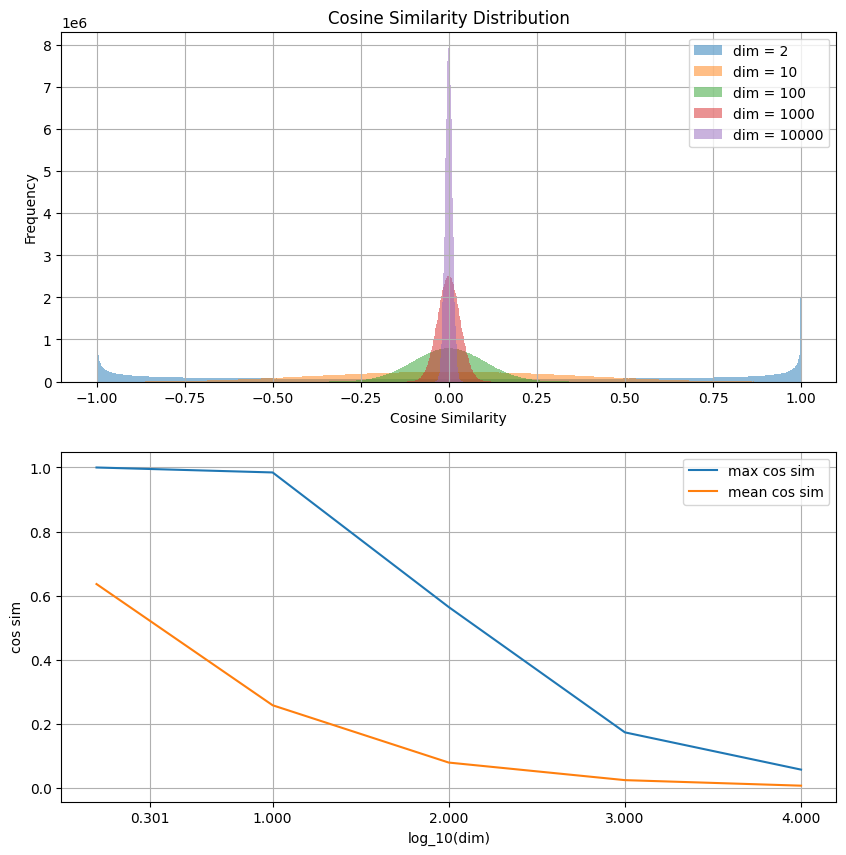

In [ ]:
fig, axes = plt.subplots(2, figsize = (10,10))
for cos_sim, dim in zip(cos_sims, dim_list):
  axes[0].hist(cos_sim.numpy().ravel(), bins = 1000, range = (-1,1), alpha = 0.5, label = f"dim = {dim}" )
axes[0].grid(1)
axes[0].legend()
axes[0].set_xlabel("Cosine Similarity")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Cosine Similarity Distribution")

axes[1].plot([torch.max(torch.abs(cos_sim)) for cos_sim in cos_sims], label = 'max cos sim')
axes[1].plot([torch.mean(torch.abs(cos_sim)) for cos_sim in cos_sims], label = 'mean cos sim')
axes[1].set_xlabel('log_10(dim)')
axes[1].set_xticks([np.log10(dim) for dim in dim_list])
axes[1].set_ylabel('cos sim')
# axes[1].set_title("Mean cosine similarity")
axes[1].grid(1)
axes[1].legend()
plt.show()

# Experimental Setup with OpenAI's GPT2-small SAE

For this investigation, we'll analyze feature orthogonality using the **OpenAI Sparse Autoencoder (SAE)** trained on GPT-2 Small's activations. Key specifications from their implementation:

*Scaling and evaluating sparse autoencoders, OPENAI* [paper](https://arxiv.org/pdf/2406.04093v1)  [repo](https://arxiv.org/pdf/2406.04093v1)

- **Input**: Residual stream of GPT-2 small, training context length  = 64
- **Baseline ReLU autoencoder**: For an input vector $x\in \mathbb{R}^d$, the encoder and decoder are defined by:
$$z = ReLU(Wenc(x − b_{pre}) + b_{enc})$$
$$ˆx = W_{dec}z + b_{pre}$$ with $W_{enc} ∈ \mathbb{R}^{n\times d}, b_{enc} \in \mathbb{R^n}, W_{dec} \in \mathbb{R}^{d \times n},$ and $b_{pre} ∈ \mathbb{R}^d$. The training loss is defined by
$$L = ||x − \hat{x}||^2 + λ||z||_1,$$ where $||x − \hat{x}||^2$
 is the reconstruction MSE, $||z||_1$ is an L1 penalty promoting
sparsity in latent activations $z$, and $\lambda$ is a hyperparameter that needs to be tuned
- **TopK** K-sparse autoencoder defined usig TopK activation function: The ecoder is modified as $$z = TopK(W_{enc}(x − b_{pre}).$$ removing the need for $L_1$ penalty from the loss functions
- **Expansion Factor**: ~42× (768  → 32,768 dimensional latent space)
- **Sparsity**: k = 32

In [ ]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2", center_writing_weights=False).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu


In [ ]:
def get_layer_name(location: str, layer_index:int):
    transformer_lens_loc = {
        "mlp_post_act": f"blocks.{layer_index}.mlp.hook_post",
        "resid_delta_attn": f"blocks.{layer_index}.hook_attn_out",
        "resid_post_attn": f"blocks.{layer_index}.hook_resid_mid",
        "resid_delta_mlp": f"blocks.{layer_index}.hook_mlp_out",
        "resid_post_mlp": f"blocks.{layer_index}.hook_resid_post",
    }[location]

    return transformer_lens_loc

In [ ]:
from IPython.display import Image
img_url = "https://transformerlensorg.github.io/TransformerLens/_downloads/ee2d5f417d3b64d0f61ec8a9ede5f15b/TransformerLens_Diagram.svg"
display(Image(url=img_url))

In [ ]:
input = "You will rejoice to hear that no disaster has accompanied the commencement of an enterprise which you have regarded with such evil forebodings."
input_2 =  "I arrived here yesterday, and my first task is to assure my dear sister of my welfare and increasing confidence in the success of my undertaking. "
tokens = model.to_tokens(input)  # (1, n_tokens)
with torch.no_grad():
    logits, activation_cache = model.run_with_cache(tokens, remove_batch_dim=False)


In [ ]:
'''download SAE weights'''
import blobfile as bf
layer_index = 10
location = "resid_post_mlp"

with bf.BlobFile(sae.paths.v5_32k(location, layer_index), mode="rb") as f:
    print(f"location = {location}, layer_index = {layer_index}")
    print(f"fetching weights for SAE at layer: {get_layer_name(location, layer_index),} from:  {sae.paths.v5_32k(location, layer_index)}")
    state_dict = torch.load(f)


location = resid_post_mlp, layer_index = 10
fetching weights for SAE at layer: ('blocks.10.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_32k/autoencoders/10.pt


In [ ]:
autoencoder = sae.Autoencoder.from_state_dict(state_dict).to(device)

layer_name = get_layer_name(location, layer_index)
input_tensor = activation_cache[layer_name]

with torch.no_grad():
    latent_activations, info = autoencoder.encode(input_tensor)
    reconstructed_activations = autoencoder.decode(latent_activations, info)

print(f'input tensor: {input_tensor.shape}')
print(f'latent activations: {latent_activations.shape}')
print(f'reconstructed activations: {reconstructed_activations.shape}')

input tensor: torch.Size([1, 28, 768])
latent activations: torch.Size([1, 28, 32768])
reconstructed activations: torch.Size([1, 28, 768])


In [ ]:
def random_row_subset(tensor, r):
    R = tensor.size(0)
    # Generate random indices without replacement
    rand_indices = torch.randperm(R)[:r]
    # Select the rows
    subset = tensor[rand_indices]
    return subset

Here are the key expected differences between SAE-learned features and random vectors:


## Almost Orthogonality


decoder weights shape: torch.Size([768, 32768])


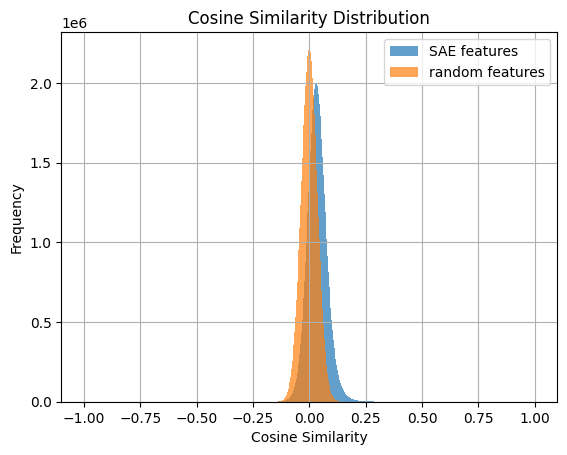

In [ ]:

# encoder_weights = state_dict['encoder.weight']
# decoder_weights = state_dict['decoder.weight']

# print(encoder_weights.size())
# print(decoder_weights.size())

autoencoder.eval()

decoder_weights = autoencoder.decoder.weight
res_dim, sae_dim = decoder_weights.shape
print(f'decoder weights shape: {decoder_weights.shape}')


big_matrix = decoder_weights.T
big_matrix = random_row_subset(big_matrix, r = 10000)

num_vecs, dim = big_matrix.shape
dot_products = big_matrix@big_matrix.T
norms = torch.sqrt(torch.diag(dot_products))

outer_norms =  torch.outer(norms, norms)

cos_sim = dot_products/outer_norms
self_orthogonality_mask =  ~(torch.eye(num_vecs, num_vecs).bool())
cos_sim = cos_sim[self_orthogonality_mask]
plt.hist(cos_sim.detach().cpu().ravel(), bins = 1000, range = (-1,1), alpha = 0.7, label = 'SAE features')

#------random SAE weights------
big_matrix_random = torch.randn(num_vecs, dim)
dot_products_random = big_matrix_random @ big_matrix_random.T
norms_random = torch.sqrt(torch.diag(dot_products_random))
cos_sim_random = dot_products_random/ torch.outer(norms_random, norms_random)
cos_sim_random = cos_sim_random[self_orthogonality_mask]

plt.hist(cos_sim_random.detach().cpu().ravel(), bins = 1000, range = (-1,1), alpha = 0.7, label = 'random features')
plt.title("Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(1)
plt.show()

# Sparsity Structure

- Random features: Bernoulli-like activation patterns

- SAE features: Only ~300/30k features active per token


token activation shape: torch.Size([768])
SAE active features = 302/32768
sparsity = 0.00921630859375
random active features = 16136/32768


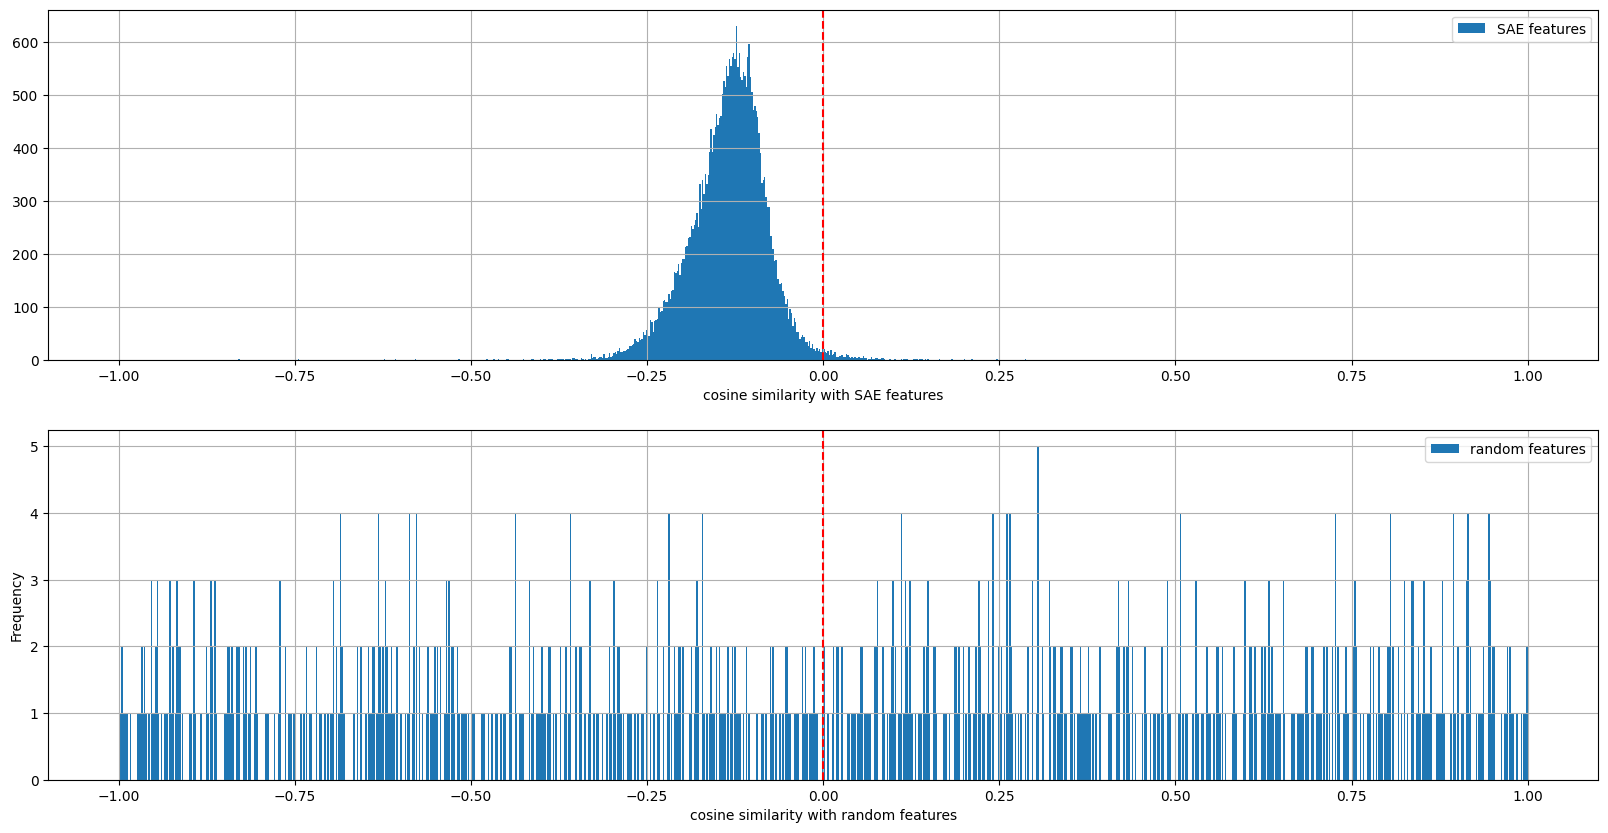

In [ ]:
#Activation for the final token in the input text
act = activation_cache[layer_name][0, -1, :]
print(f"token activation shape: {act.shape}")


fig, axes = plt.subplots(2, figsize = (20,10))
# x = np.linspace(0, dim, dim)

#dot product of token activation with all SAE features
act_dots = act @ decoder_weights
acts_norm = act.norm(p=2, dim=-1)
decoder_norm = decoder_weights.norm(p=2, dim = 0)
#cosine similarity of activation with all the SAE features
act_cos_sim = (act_dots)/acts_norm*decoder_norm

mask = act_cos_sim > 0.

print(f'SAE active features = {torch.sum(mask)}/{sae_dim}')
sparsity = torch.sum(mask)/sae_dim
print(f'sparsity = {sparsity}')

decoder_weights_random = torch.randn(decoder_weights.shape).to(device)
act_dots_random = act @ decoder_weights_random
decoder_random_norm = decoder_weights_random.norm(p=2, dim=0)
act_cos_sim_random = act_dots_random/acts_norm*decoder_random_norm

mask = act_cos_sim_random > 0.
print(f'random active features = {torch.sum(mask)}/{sae_dim}')


axes[0].hist(act_cos_sim.detach().cpu(), bins = 1000, range = (-1,1), label = 'SAE features')
axes[1].hist(act_cos_sim_random.detach().cpu(), bins = 1000, range = (-1,1), label = 'random features')

axes[0].axvline(x=0., color='r', linestyle='--')
axes[1].axvline(x=0., color='r', linestyle='--')
plt.grid(True)
axes[0].grid(True)
axes[1].grid(True)
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("cosine similarity with SAE features")
axes[1].set_xlabel("cosine similarity with random features")
plt.ylabel("Frequency")
fig.show()


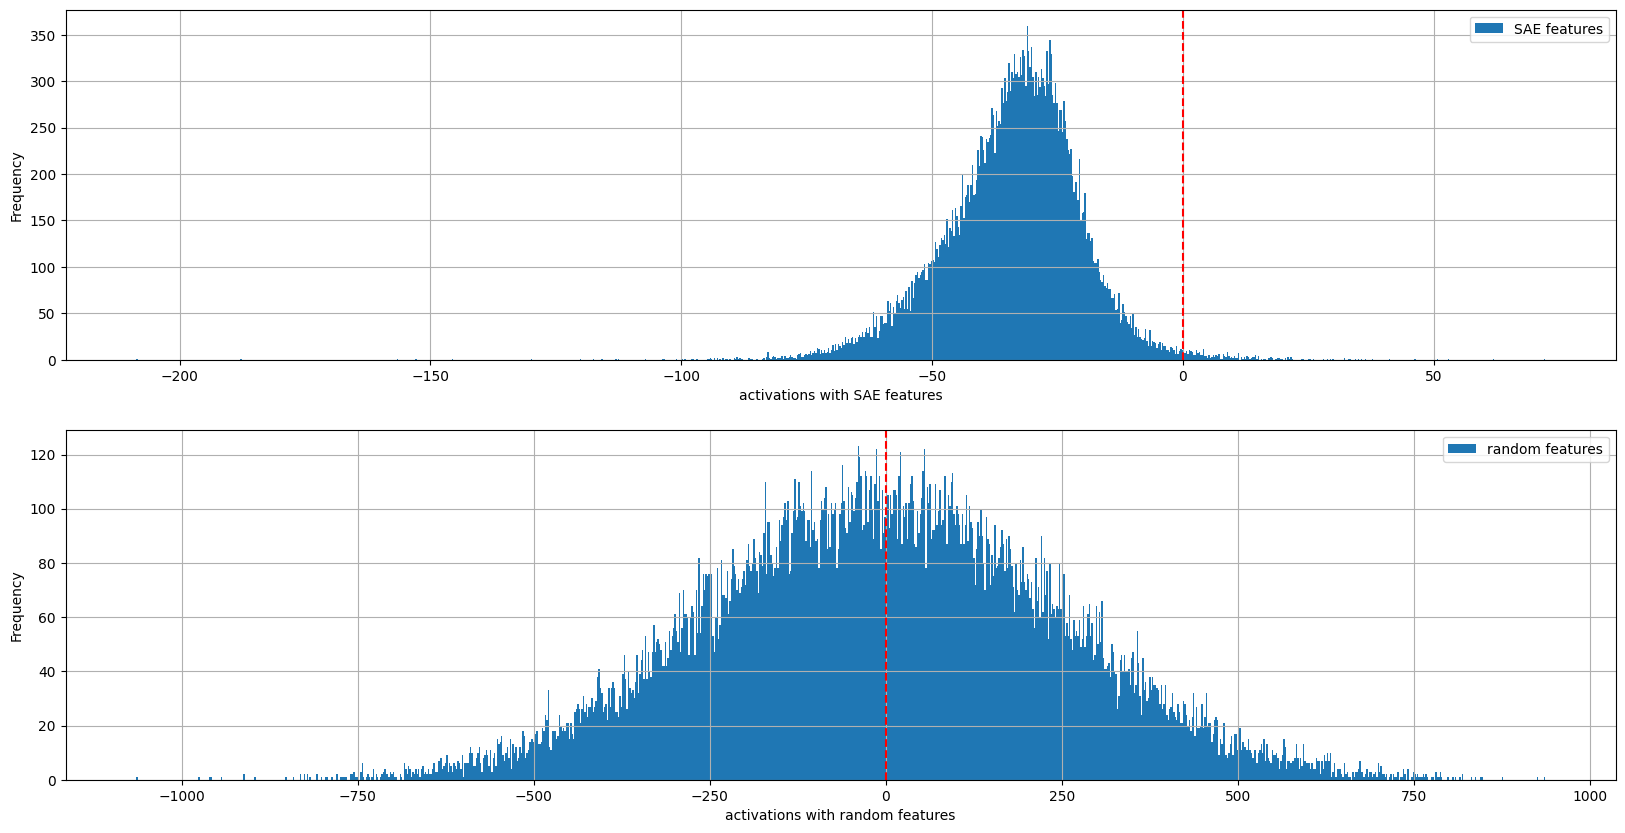

In [ ]:
fig, axes = plt.subplots(2, figsize = (20,10))
axes[0].hist(act_dots.detach().cpu(), bins = 1000, label = 'SAE features')
axes[1].hist(act_dots_random.detach().cpu(), bins = 1000, label = 'random features')

axes[0].axvline(x=0., color='r', linestyle='--')
axes[1].axvline(x=0., color='r', linestyle='--')

axes[0].grid(True)
axes[1].grid(True)
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("activations with SAE features")
axes[1].set_xlabel("activations with random features")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
fig.show()

In [ ]:
#Find the SAE latent with top activation
top_feature = decoder_weights[:, torch.argmax(act_dots)]

## Summarize sparsity over all layers

## SAE version `v5_32k` (TopK sparsity)
- Number of autoencoder latents: 2**15 = 32768
- Number of training tokens:  TODO
- Activation function: **TopK(32)**
- L1 regularization strength: n/a
- Layer normed inputs: true

In [ ]:

layers = range(12)
# locations = ["resid_delta_attn", "resid_post_attn", "resid_delta_mlp", "resid_post_mlp"]
locations = ["resid_post_mlp"]

state_dicts_v5_32k = dict()
for layer in layers:
  for location in locations:
    with bf.BlobFile(sae.paths.v5_32k(location, layer), mode="rb") as f:
        print(f"fetching weights for SAE at layer: {get_layer_name(location, layer),} from:  {sae.paths.v5_32k(location, layer)}")
        state_dict = torch.load(f)
        state_dicts_v5_32k[get_layer_name(location, layer)] = state_dict

fetching weights for SAE at layer: ('blocks.0.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_32k/autoencoders/0.pt
fetching weights for SAE at layer: ('blocks.1.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_32k/autoencoders/1.pt
fetching weights for SAE at layer: ('blocks.2.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_32k/autoencoders/2.pt
fetching weights for SAE at layer: ('blocks.3.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_32k/autoencoders/3.pt
fetching weights for SAE at layer: ('blocks.4.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_32k/autoencoders/4.pt
fetching weights for SAE at layer: ('blocks.5.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_32k/autoencoders/5.pt
fetching weights for SAE at layer: ('blo

In [ ]:
from tqdm import tqdm

def get_scores(state_dict_version: dict) -> dict:
  scores = {'layer_names': [], 'reconstruction_losses': [], 'sparsity_scores': []}

  for layer_name, state_dict in tqdm(state_dict_version.items()):
    scores['layer_names'].append(layer_name)

    input_tensor = activation_cache[layer_name]
    act = activation_cache[layer_name][0, -1, :]

    try:
      autoencoder = sae.Autoencoder.from_state_dict(state_dict).to(device)
      input_tensor = activation_cache[layer_name]

      with torch.no_grad():
          latent_activations, info = autoencoder.encode(input_tensor)
          reconstructed_activations = autoencoder.decode(latent_activations, info)

      reconstruction_loss = (reconstructed_activations[0,-1,:] - input_tensor[0,-1,:]).norm(p=2)
      # print(f'reconstruction loss: {reconstruction_loss}')
      scores['reconstruction_losses'].append(reconstruction_loss)

      decoder_weights = autoencoder.decoder.weight

    except Exception as err:
      print(f'Exception in layer {layer_name}, Error: {err}')

      scores['reconstruction_losses'].append(torch.tensor(np.nan))

      decoder_weights = state_dict['decoder.weight'].to(device)

    res_dim, sae_dim = decoder_weights.shape

    act_dots = act @ decoder_weights
    mask  = act_dots > 0.
    sparsity = torch.sum(mask)
    # print(f'sparsity = {sparsity}')
    scores['sparsity_scores'].append(sparsity)

  return scores


In [ ]:
v5_32k_scores = get_scores(state_dicts_v5_32k)

100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


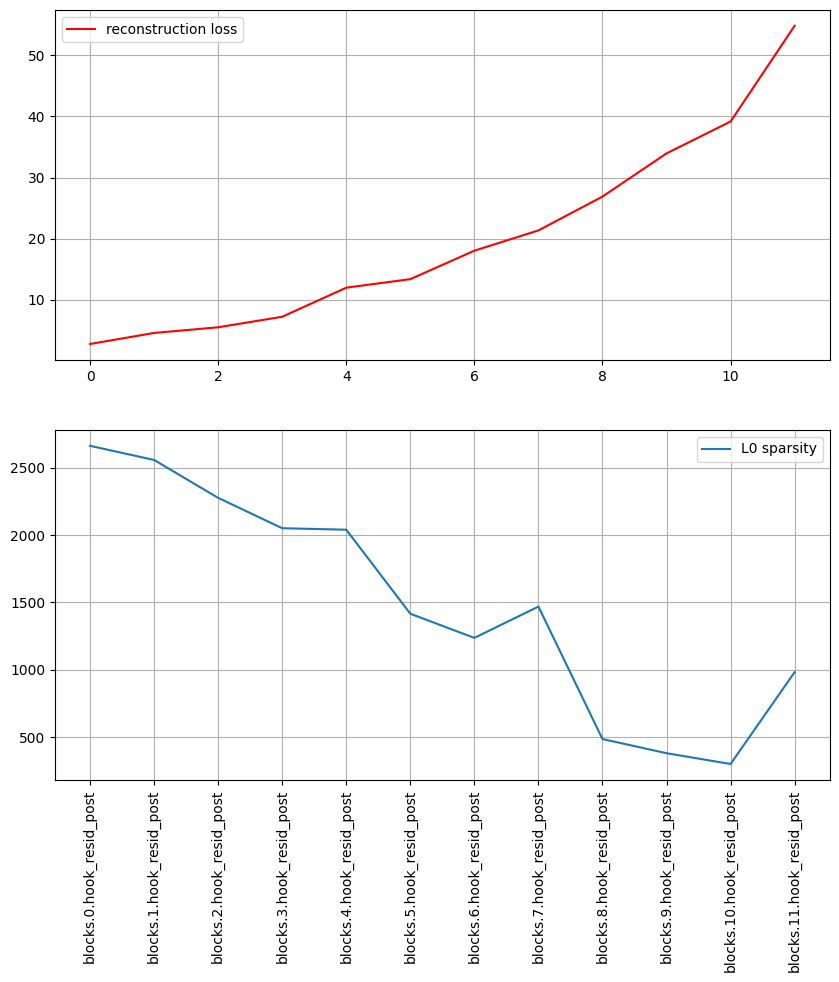

In [ ]:
sparsity_sores = v5_32k_scores['sparsity_scores']
layer_names = v5_32k_scores['layer_names']
reconstruction_losses = v5_32k_scores['reconstruction_losses']

fig, axes = plt.subplots(2, figsize = (10,10))
x = range(len(layer_names))
axes[0].plot(x, [r.detach().cpu() for r in reconstruction_losses], label = 'reconstruction loss', c  ='r')
axes[1].plot(x , [ss.detach().cpu() for ss in sparsity_sores], label = 'L0 sparsity')
axes[0].grid(1)
axes[1].grid(1)
axes[0].legend()
axes[1].legend()
axes[1].set_xticks(x)
axes[1].set_xticks(x)
axes[1].set_xticklabels(layer_names, rotation = 90)
plt.show()

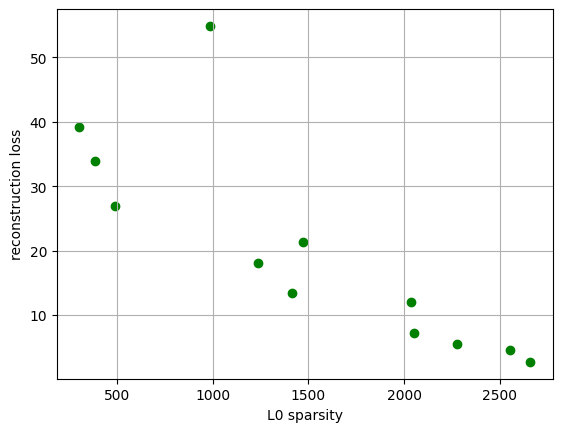

In [ ]:
plt.scatter(y = [r.detach().cpu() for r in reconstruction_losses], x = [ss.detach().cpu() for ss in sparsity_sores], c= 'g')
plt.ylabel('reconstruction loss')
plt.xlabel('L0 sparsity')
plt.grid(1)

In [ ]:
del state_dicts_v5_32k

## SAE version `v1` (L1 sparsity)
- autoencoder latents: 2*815 = 32768
- number of training tokens: ~64M
- Activation function ReLU
- L1 reg strength: 0.01




In [ ]:
layers = range(12)
locations = ["resid_delta_mlp"]

state_dicts_v1 = dict()
for layer in layers:
  for location in locations:
    with bf.BlobFile(sae.paths.v1(location, layer), mode="rb") as f:
        print(f"fetching weights for SAE at layer: {get_layer_name(location, layer)} from:  {sae.paths.v1(location, layer)}")
        state_dict = torch.load(f)
        state_dicts_v1[get_layer_name(location, layer)] = state_dict

fetching weights for SAE at layer: ('blocks.0.hook_mlp_out',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_delta_mlp/autoencoders/0.pt
fetching weights for SAE at layer: ('blocks.1.hook_mlp_out',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_delta_mlp/autoencoders/1.pt
fetching weights for SAE at layer: ('blocks.2.hook_mlp_out',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_delta_mlp/autoencoders/2.pt
fetching weights for SAE at layer: ('blocks.3.hook_mlp_out',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_delta_mlp/autoencoders/3.pt
fetching weights for SAE at layer: ('blocks.4.hook_mlp_out',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_delta_mlp/autoencoders/4.pt
fetching weights for SAE at layer: ('blocks.5.hook_mlp_out',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_delta_mlp/autoencoders/5.pt
fetching weights for SAE at layer: ('blocks.6.hook_mlp_out',) from:  az://openaipublic/sparse-

In [ ]:
v1_scores  = get_scores(state_dicts_v1)

  8%|▊         | 1/12 [00:00<00:09,  1.11it/s]

Exception in layer blocks.0.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 17%|█▋        | 2/12 [00:01<00:05,  1.68it/s]

Exception in layer blocks.1.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 25%|██▌       | 3/12 [00:01<00:04,  2.10it/s]

Exception in layer blocks.2.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 33%|███▎      | 4/12 [00:01<00:03,  2.39it/s]

Exception in layer blocks.3.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 42%|████▏     | 5/12 [00:02<00:02,  2.51it/s]

Exception in layer blocks.4.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 50%|█████     | 6/12 [00:02<00:02,  2.60it/s]

Exception in layer blocks.5.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 58%|█████▊    | 7/12 [00:03<00:01,  2.71it/s]

Exception in layer blocks.6.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 67%|██████▋   | 8/12 [00:03<00:01,  2.78it/s]

Exception in layer blocks.7.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 75%|███████▌  | 9/12 [00:03<00:01,  2.82it/s]

Exception in layer blocks.8.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 83%|████████▎ | 10/12 [00:04<00:00,  2.89it/s]

Exception in layer blocks.9.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


 92%|█████████▏| 11/12 [00:04<00:00,  2.95it/s]

Exception in layer blocks.10.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


100%|██████████| 12/12 [00:04<00:00,  2.58it/s]

Exception in layer blocks.11.hook_mlp_out, Error: Error(s) in loading state_dict for Autoencoder:
	Missing key(s) in state_dict: "latents_activation_frequency", "latents_mean_square". 


/tmp/ipython-input-4066570740.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


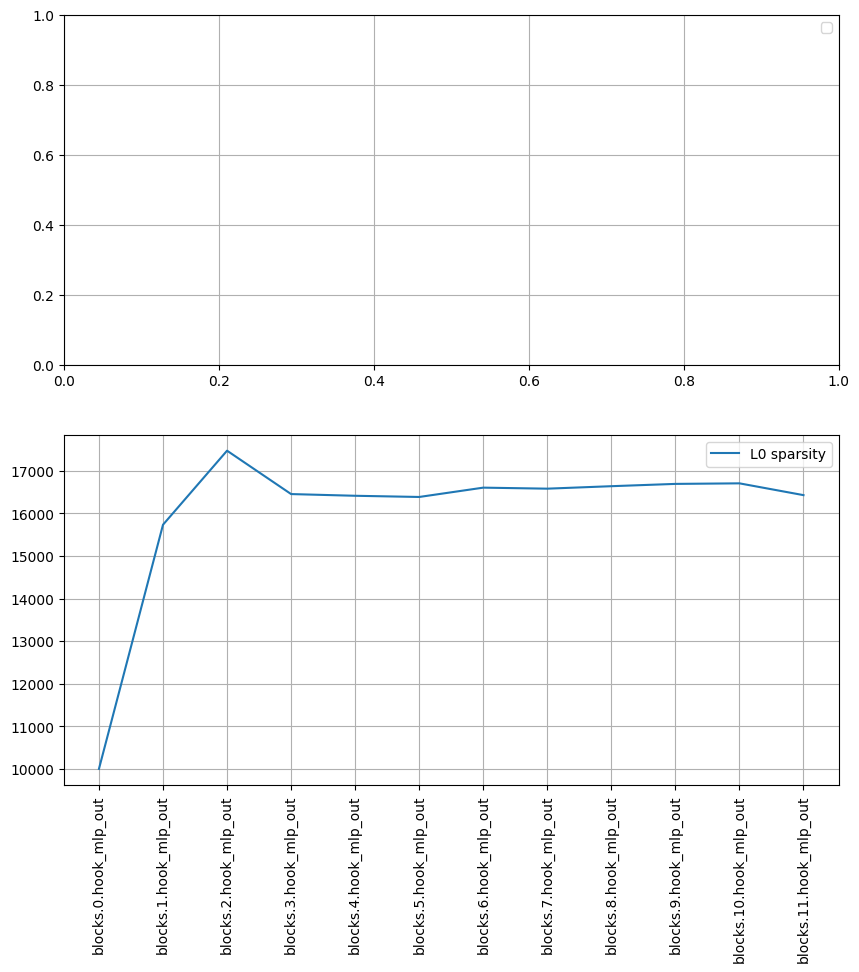

In [ ]:
sparsity_sores = v1_scores['sparsity_scores']
layer_names = v1_scores['layer_names']
reconstruction_losses = v1_scores['reconstruction_losses']

fig, axes = plt.subplots(2, figsize = (10,10))
x = range(len(layer_names))
# axes[0].plot(x, [r.detach().cpu() for r in reconstruction_losses], label = 'reconstruction loss', c  ='r')
axes[1].plot(x , [ss.detach().cpu() for ss in sparsity_sores], label = 'L0 sparsity')
axes[0].grid(1)
axes[1].grid(1)
axes[0].legend()
axes[1].legend()
axes[1].set_xticks(x)
axes[1].set_xticks(x)
axes[1].set_xticklabels(layer_names, rotation = 90)
plt.show()

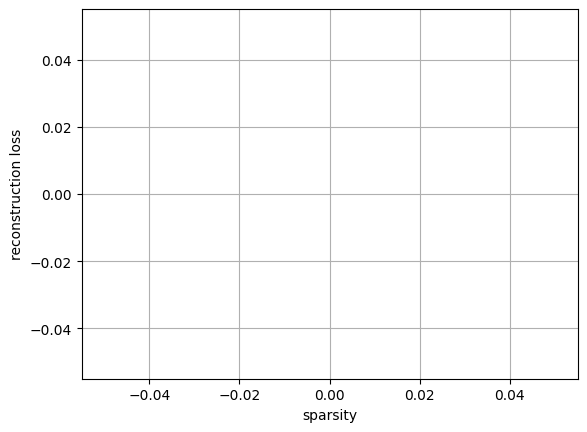

In [ ]:
plt.scatter(y = [r.detach().cpu() for r in reconstruction_losses], x = [ss.detach().cpu() for ss in sparsity_sores], c= 'g')
plt.ylabel('reconstruction loss')
plt.xlabel('sparsity')
plt.grid(1)

In [ ]:
del state_dicts_v1

## SAE version `v5_128k`
- no. of autoencoder latents: 2**17 = 131072
- TopK(32)

In [ ]:
layers = range(12)
# locations = ["resid_delta_attn", "resid_delta_mlp", "resid_post_attn", "resid_post_mlp"]
locations = ["resid_post_mlp"]
state_dicts_v5_128k = dict()
for layer in layers:
  for location in locations:
    with bf.BlobFile(sae.paths.v5_128k(location, layer), mode="rb") as f:
        print(f"fetching weights for SAE at layer: {get_layer_name(location, layer),} from:  {sae.paths.v5_128k(location, layer)}")
        state_dict = torch.load(f)
        state_dicts_v5_128k[get_layer_name(location, layer)] = state_dict

fetching weights for SAE at layer: ('blocks.0.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/0.pt
fetching weights for SAE at layer: ('blocks.1.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/1.pt
fetching weights for SAE at layer: ('blocks.2.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/2.pt
fetching weights for SAE at layer: ('blocks.3.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/3.pt
fetching weights for SAE at layer: ('blocks.4.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/4.pt
fetching weights for SAE at layer: ('blocks.5.hook_resid_post',) from:  az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/5.pt
fetching weights for SAE at layer:

In [ ]:
v5_128k_scores = get_scores(state_dicts_v5_128k)

100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


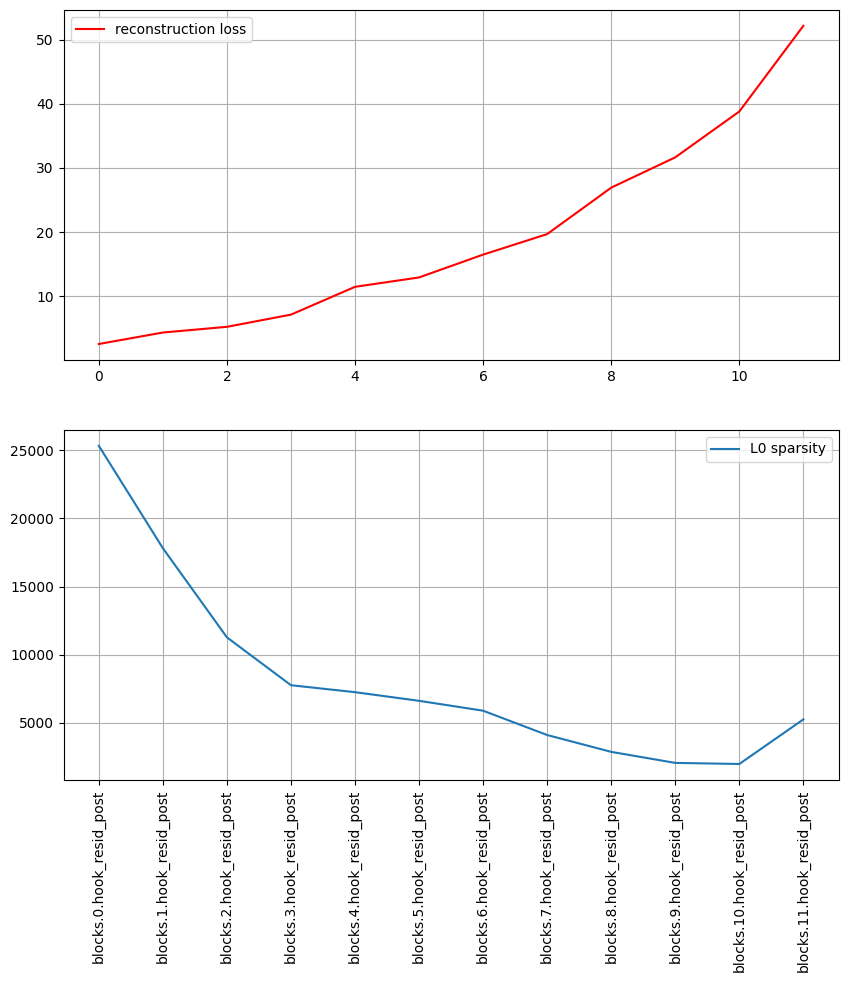

In [ ]:
sparsity_sores = v5_128k_scores['sparsity_scores']
layer_names = v5_128k_scores['layer_names']
reconstruction_losses = v5_128k_scores['reconstruction_losses']

fig, axes = plt.subplots(2, figsize = (10,10))
x = range(len(layer_names))
axes[0].plot(x, [r.detach().cpu() for r in reconstruction_losses], label = 'reconstruction loss', c  ='r')
axes[1].plot(x , [ss.detach().cpu() for ss in sparsity_sores], label = 'L0 sparsity')
axes[0].grid(1)
axes[1].grid(1)
axes[0].legend()
axes[1].legend()
axes[1].set_xticks(x)
axes[1].set_xticks(x)
axes[1].set_xticklabels(layer_names, rotation = 90)
plt.show()

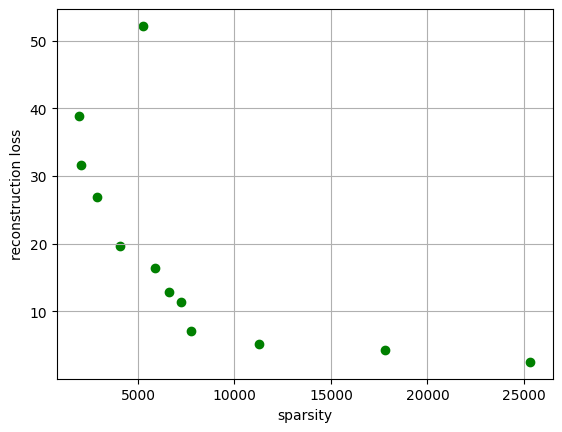

In [ ]:
plt.scatter(y = [r.detach().cpu() for r in reconstruction_losses], x = [ss.detach().cpu() for ss in sparsity_sores], c= 'g')
plt.ylabel('reconstruction loss')
plt.xlabel('sparsity')
plt.grid(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
torch.save(state_dicts_v5_128k, '/content/drive/MyDrive/models/sae/state_dicts_v5_128k.pt')

Mounted at /content/drive
